# Create adversarial samples 

In [1]:
bucket="aegovan-data"

train_data = f"s3://{bucket}/chemprot/chemprot_abstract_train.json"

output_data = f"s3://{bucket}/chemprot_adversarial/"

In [2]:
import pandas as pd
import sagemaker, io

In [3]:
df = pd.read_json( io.StringIO(sagemaker.s3.S3Downloader.read_file(train_data)))
df.sample(n=3)

,abstract_id,abstract,participant1_id,participant1,participant2_id,participant2,annotations,relationship_type,relationship_group,is_eval,label
5841,23643730,"Juglone, isolated from Juglans mandshurica Max...",T2,"{'abstract_id': '23643730', 'id': 'T2', 'entit...",T20,"{'abstract_id': '23643730', 'id': 'T20', 'enti...","[{'abstract_id': '23643730', 'id': 'T1', 'enti...",INDIRECT-DOWNREGULATOR,CPR:4,Y,CPR:4
3070,19203467,Neurochemical effects of the monoamine oxidase...,T5,"{'abstract_id': '19203467', 'id': 'T5', 'entit...",T62,"{'abstract_id': '19203467', 'id': 'T62', 'enti...","[{'abstract_id': '19203467', 'id': 'T1', 'enti...",INHIBITOR,CPR:4,Y,CPR:4
3393,21262851,Inhibition of recombinant L-type voltage-gated...,T18,"{'abstract_id': '21262851', 'id': 'T18', 'enti...",T52,"{'abstract_id': '21262851', 'id': 'T52', 'enti...","[{'abstract_id': '21262851', 'id': 'T1', 'enti...",INHIBITOR,CPR:4,Y,CPR:4


<AxesSubplot:ylabel='Frequency'>

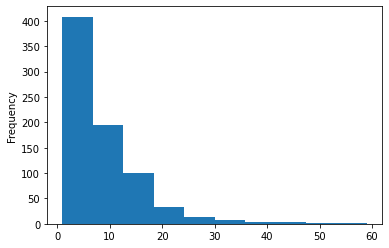

In [4]:
df.groupby(["abstract_id"]).size().plot.hist()

In [5]:
df.groupby(["abstract_id"]).size().describe()

count    767.000000
mean       8.392438
std        7.643567
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max       59.000000
dtype: float64

In [6]:
df.groupby(["label"]).size()

label
CPR:3        777
CPR:4       2260
CPR:5        173
CPR:6        235
CPR:9        727
NEGATIVE    2265
dtype: int64

In [7]:
df.groupby(["abstract_id", "label"]).size().describe()

count    1382.000000
mean        4.657742
std         4.838381
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        58.000000
dtype: float64

In [8]:
df.query("label == 'NEGATIVE' or label == 'CPR:4'").shape

(4525, 11)

<AxesSubplot:ylabel='Frequency'>

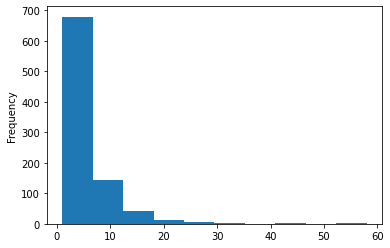

In [9]:
df.query("label == 'NEGATIVE' or label == 'CPR:4'").groupby(["abstract_id", "label"]).size().plot.hist()

{'UniquePositives': 210, 'AllPositives': 777, 'UniquePositiveSampleRate': 0.03262389311791207, 'PositiveSampleRate': 0.12070840453627467, 'UniqueNonAdversarialNegatives': 557, 'AllNonAdversarialNegatives': 4145, 'UniqueAdversarialNegatives': 183, 'AllAdversarialNegatives': 1515, 'AdversarialRate': 7.214285714285714, 'UniqueAdversarialRate': 0.8714285714285714, 'TotalSize': 6437}
s3://aegovan-data/chemprot_adversarial/train_767_210_0.json {'UniquePositives': 210, 'AllPositives': 210, 'UniquePositiveSampleRate': 0.2737940026075619, 'PositiveSampleRate': 0.2737940026075619, 'UniqueNonAdversarialNegatives': 557, 'AllNonAdversarialNegatives': 557, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 767}
s3://aegovan-data/chemprot_adversarial/train_767_210_21.json {'UniquePositives': 210, 'AllPositives': 210, 'UniquePositiveSampleRate': 0.2737940026075619, 'PositiveSampleRate': 0.2737940026075619, 'UniqueNonAdversa

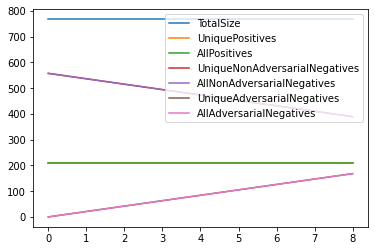

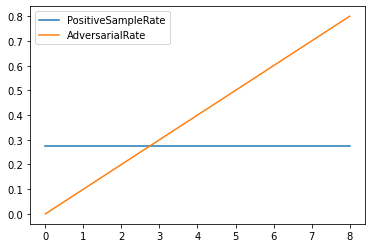

In [11]:
import numpy as np

def get_stats(df, pos_label):
    stats ={}
    
    # Positive samples
    df_positive = df.query(f"label == '{pos_label}'")
    df_positive_unique = df_positive.drop_duplicates('abstract_id')
    stats["UniquePositives"] = len(df_positive_unique)
    stats["AllPositives"] = len(df_positive)

    stats["UniquePositiveSampleRate"] = stats["UniquePositives"]/(len(df))
    stats["PositiveSampleRate"] = stats["AllPositives"]/(len(df))
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"label == '{pos_label}'")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries = df[~abstracts_id_with_positive]
    df_negative_non_adverseries_unique =df_negative_non_adverseries.drop_duplicates('abstract_id')
    stats["UniqueNonAdversarialNegatives"] = len(df_negative_non_adverseries_unique)
    stats["AllNonAdversarialNegatives"] = len(df_negative_non_adverseries)

    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries = df[abstracts_id_with_positive].query(f"label != '{pos_label}'")
    df_negative_adverseries_unique = df_negative_adverseries.drop_duplicates('abstract_id')
    stats["UniqueAdversarialNegatives"] = len(df_negative_adverseries_unique)
    stats["AllAdversarialNegatives"] = len(df_negative_adverseries)
    
    # TODO: Check if unique positive is appropriate
    stats["AdversarialRate"] = stats["AllAdversarialNegatives"]/len(df_positive_unique)
    stats["UniqueAdversarialRate"] = stats["UniqueAdversarialNegatives"]/len(df_positive_unique)


    stats["TotalSize"] = len(df)

    return stats


def mixmatch_training_data(df, discriminitory_rate, pos_label):
    
    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"label == '{pos_label}'").drop_duplicates('abstract_id')
    df_positive_unique_sim = df.query(f"label == '{pos_label}'")
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"label == '{pos_label}'")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')
    
    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries_unique = df[abstracts_id_with_positive].query(f"label != '{pos_label}'").drop_duplicates('abstract_id')
    
    df_negative_adverseries_simi = df[abstracts_id_with_positive].query(f"label != '{pos_label}'")
    
    
    discriminitory_size = int(len(df_positive_unique)  * discriminitory_rate)
    if discriminitory_size > 0:
        drop_indices = np.random.choice(df_negative_non_adverseries_unique.index, discriminitory_size, replace=False)
      
        df_negative_non_adverseries_unique = df_negative_non_adverseries_unique.drop(drop_indices).copy()
        
        df_negative_adverseries_unique = df_negative_adverseries_unique.sample(n=discriminitory_size).copy()
        
        df_negative_adverseries_unique["label"] = 'NEGATIVE'
        df_negative_non_adverseries_unique["label"] =  'NEGATIVE'
    else:
        # Empty adversarial unique
        df_negative_adverseries_unique = pd.DataFrame()
     
    
    final_data = pd.concat([df_positive_unique, 
                            df_negative_non_adverseries_unique, 
                            df_negative_adverseries_unique]).reset_index()
    
    
    return final_data

def create_samples_and_upload_to_s3(df, s3_uri_base):
    pos_label = "CPR:3"

    stats = []
    for i in range(0, 9):

        df_train_data = mixmatch_training_data(df, discriminitory_rate=i/10, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=pos_label)
        stats.append(stat )
        
        json_data = io.StringIO() 
        df_train_data.to_json( json_data )
        
        s3_uri = "{}/{}".format( s3_uri_base.rstrip("/"), f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["UniqueAdversarialNegatives"]}.json')
        print(s3_uri, stat )
        
        sagemaker.s3.S3Uploader.upload_string_as_file_body(json_data.getvalue(), s3_uri)
        

    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate"]].plot.line()

print(get_stats(df, "CPR:3"))
create_samples_and_upload_to_s3(df, output_data)

In [ ]:
mixmatch_training_data(df, discriminitory_rate=2/10, pos_label="CPR:3")  

 Start with random base sample pos = 1000
  drate = 0
= 1000 p + 2000 negative [3000, drate 0, 33% positive rate]

= 1000 p + 1700 + 300 derived             [3000, .10, 33% positive rate]

= 1000 p + 1400 + 600 dervied   [3000, .20, 33% positive rate]

= 1000 p + 1100 + 900 dervied   [3000, .30, 33% positive rate]

= 1000 p + 800 + 1200 dervied ,  [ .40]

= 1000 p + 500 + 1500, dervied ,  [ .50]

= 1000 p +  0 + 2000 dervied ,  [ 1]

= 



Discrimintory strength rate for label p = derived samples  that change base label p / base labels for p

similarity rate  = derived samples that do not change the label / total sample = 0
